In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!chmod 600 ~/.kaggle/kaggle.json


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:51<00:00, 18.9MB/s]
100% 1.04G/1.04G [00:51<00:00, 21.7MB/s]


In [4]:
# Unzip the downloaded dataset
!unzip flickr8k.zip -d flickr8k


Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/28507194

In [5]:
!ls flickr8k


captions.txt  Images


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from textwrap import wrap
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model, Sequential
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Reshape, Dense, Embedding, Dropout, Concatenate, concatenate, LSTM, add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [7]:
# Directory containing images
image_dir = 'flickr8k/Images'

# Example: List the first 10 image files
images = os.listdir(image_dir)
print(images[:10])


['3096918227_f9d26a7db2.jpg', '2893476169_f38dd32051.jpg', '892340814_bdd61e10a4.jpg', '997722733_0cb5439472.jpg', '3396153660_f729d9f9b9.jpg', '2125626631_a4b63af97e.jpg', '2579268572_d78f8436cb.jpg', '2666179615_f05a9d8331.jpg', '3648160673_0c783236a6.jpg', '3234375022_1464ea7f8a.jpg']


In [8]:
# Load the captions file
captions_path = 'flickr8k/captions.txt'
captions_df = pd.read_csv(captions_path)
captions_df.head()


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [9]:
def realImages(path, img_szie=224):
  img = load_img(path, color_mode = 'rgb', target_size = (img_szie, img_szie))
  img = img_to_array(img)
  img = img / 255

  return img

In [10]:
def displayImages(df):
  df = df.reset_index(drop=True)
  plt.figure(figsize = (20, 20))

  n = 0
  for i in range(15):
    n += 1
    plt.subplot(5, 5, n)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    image = realImages(f"flickr8k/Images/{df.image[i]}")
    plt.imshow(image)
    plt.title("\n".join(wrap(df.caption[i], 20)))
    plt.axis('off')

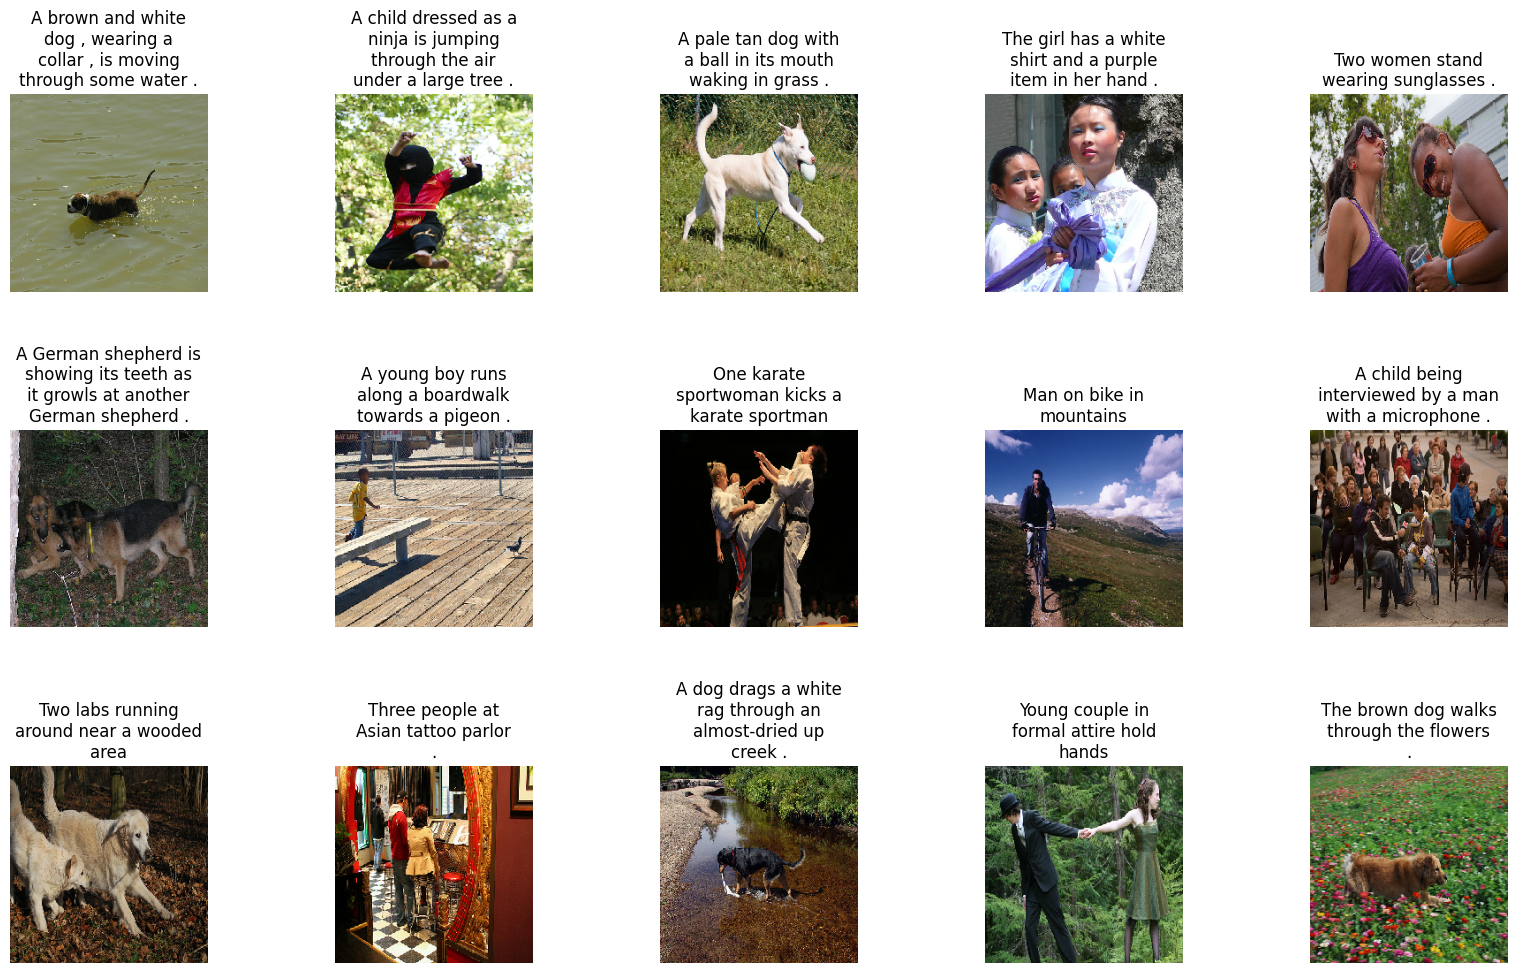

In [11]:
displayImages(captions_df.sample(15))

# Text Preprocessing for Captions

In [12]:
# convert captions into lowercase
captions_df['caption'] = captions_df['caption'].str.lower()

# remove special characters and numbers present in the text\
captions_df['caption'] = captions_df['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))

# remove extra spaces
captions_df['caption'] = captions_df['caption'].apply(lambda x: x.replace("\s+", " "))

# remove single characters
captions_df['caption'] = captions_df['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))

# add startseq and endseq tags to sentences to indicate beginning and ending of the sentence
captions_df['caption'] = "startseq " +captions_df['caption']+" endseq"

In [13]:
captions = captions_df['caption'].to_list()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [14]:
# tokenizing the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# total number of unique images
images = captions_df['image'].unique().tolist()
nimages = len(images)

# spliting the dataset into training and validation
split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# filtering dataset into training and testing dataframes
train = captions_df[captions_df['image'].isin(train_images)]
test = captions_df[captions_df['image'].isin(val_images)]

# reset indices
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# convert captions to sequences
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [15]:
# loading pre-trained desnet201 model
model = DenseNet201()

# extract second last layer as output, to obtain high level feature representstion of images
fe = Model(inputs = model.input, outputs = model.layers[-2].output)

# extract features for each image
img_size = 224
features = {}

for image in tqdm(captions_df['image'].unique().tolist()):
  img = load_img(os.path.join(image_dir, image), target_size = (img_size, img_size))
  img = img_to_array(img)
  img = img / 255
  img = np.expand_dims(img, axis = 0)
  feature = fe.predict(img, verbose = 0)
  features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


100%|██████████| 8091/8091 [10:47<00:00, 12.50it/s]


In [16]:
class CustomDataGenerator(Sequence):

  def __init__(
      self,
      df,
      x_col,
      y_col,
      batch_size,
      directory,
      tokenizer,
      vocab_size,
      max_length,
      features,
      shuffle = True
  ):
    self.df = df.copy()
    self.x_col = x_col
    self.y_col = y_col
    self.directory = directory
    self.batch_size = batch_size
    self.tokenizer = tokenizer
    self.vocab_size = vocab_size
    self.max_length = max_length
    self.features = features
    self.shuffle = shuffle
    self.n = len(self.df)

  def on_epoch_end(self):
    if self.shuffle:
      self.df = self.df.sample(frac=1).reset_index(drop=True)

  def __len__(self):
    return self.n // self.batch_size

  def __getitem__(self, index):
    batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
    x1, x2, y = self.__get_data(batch)
    return (x1, x2), y

  def __get_data(self, batch):

    x1, x2, y = list(), list(), list()

    images = batch[self.x_col].tolist()

    for image in images:
      feature = self.features[image][0]

      captions = batch.loc[batch[self.x_col] == image, self.y_col].tolist()

      for caption in captions:
        seq = self.tokenizer.texts_to_sequences([caption])[0]

        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen = self.max_length)[0]
          out_seq = to_categorical([out_seq], num_classes = self.vocab_size)[0]
          x1.append(feature)
          x2.append(in_seq)
          y.append(out_seq)
    x1, x2, y =  np.array(x1), np.array(x2), np.array(y)

    return x1, x2, y




In [17]:
input1 = Input(shape=(1920, ))
input2 = Input(shape=(max_length,))

# preprocess image features
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# process caption sequence
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# combine inmage and text features
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# sequence modeling
sentence_features = LSTM(256)(merged)

# add regularization and skip connection
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])

# dense layers for output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# model compilation
caption_model = Model(inputs = [input1, input2], outputs = output)
caption_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')


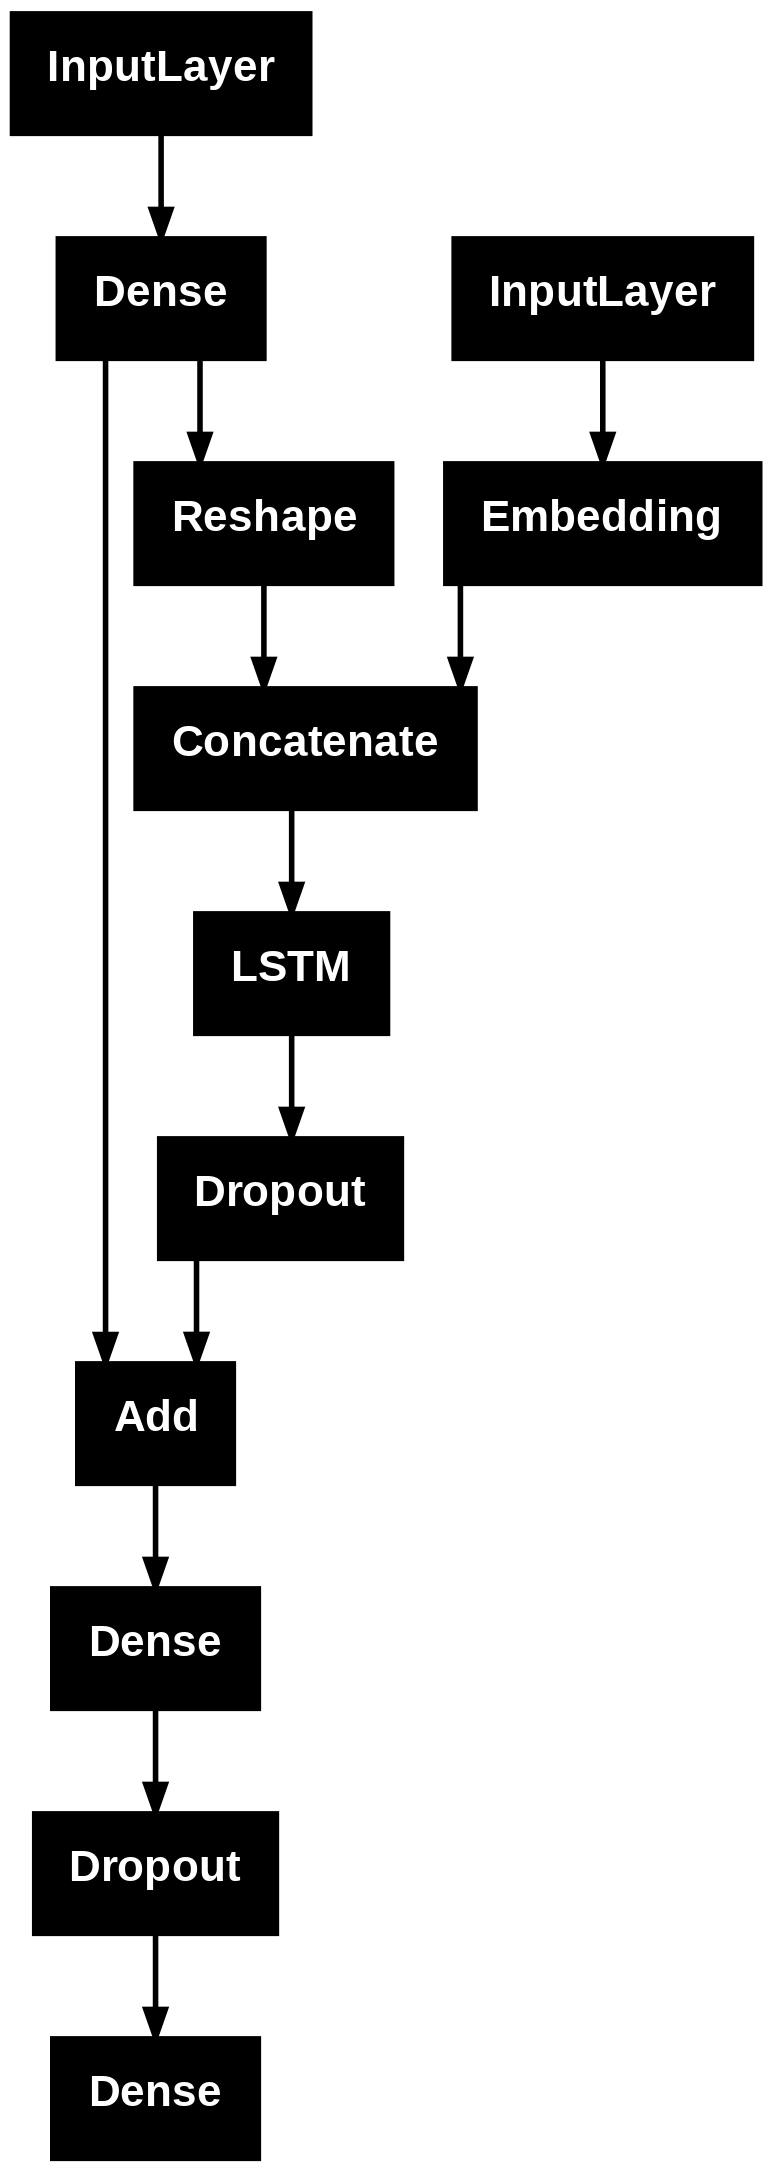

In [19]:
# plot model
plot_model(caption_model)

In [20]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        491,776 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 256)        │      2,172,160 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 35, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# feed images and captions in batches to the model in training and validation

train_generator = CustomDataGenerator(
    df = train,
    x_col = 'image',
    y_col = 'caption',
    batch_size = 64,
    directory = image_dir,
    tokenizer = tokenizer,
    vocab_size = vocab_size,
    max_length = max_length,
    features = features
)

validattion_generator = CustomDataGenerator(
    df = test,
    x_col = 'image',
    y_col = 'caption',
    batch_size = 64,
    directory = image_dir,
    tokenizer = tokenizer,
    vocab_size = vocab_size,
    max_length = max_length,
    features = features
)

In [22]:
model_name = "model.keras"

# model checkpoints
checkpoint = ModelCheckpoint(
    model_name,
    monitor = 'val_loss',
    save_best_only = True,
    mode = 'min',
    verbose = 1
)

# early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    min_delta = 0,
    restore_best_weights = True,
    verbose = 1
)

# reduce learning rate
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3,
    factor = 0.2,
    min_lr = 0.00000001,
    verbose = 1
)

In [23]:
history = caption_model.fit(
    train_generator,
    epochs = 100,
    validation_data = validattion_generator,
    callbacks = [checkpoint, early_stopping, learning_rate_reduction],
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 5.6617
Epoch 1: val_loss improved from inf to 4.18619, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 203s 363ms/step - loss: 5.6605 - val_loss: 4.1862 - learning_rate: 0.0010
Epoch 2/100
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 4.2001
Epoch 2: val_loss improved from 4.18619 to 3.89686, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - loss: 4.1999 - val_loss: 3.8969 - learning_rate: 0.0010
Epoch 3/100
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 3.9102
Epoch 3: val_loss improved from 3.89686 to 3.77478, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 56s 103ms/step - loss: 3.9102 - val_loss: 3.7748 - learning_rate: 0.0010
Epoch 4/100
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 3.7557
Epoch 4: val_loss improved from 3.77478 to 3.70815, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - loss: 3.7556 - val_loss: 3.7081 - learning_rate: 0.0010
Epoch 5/10

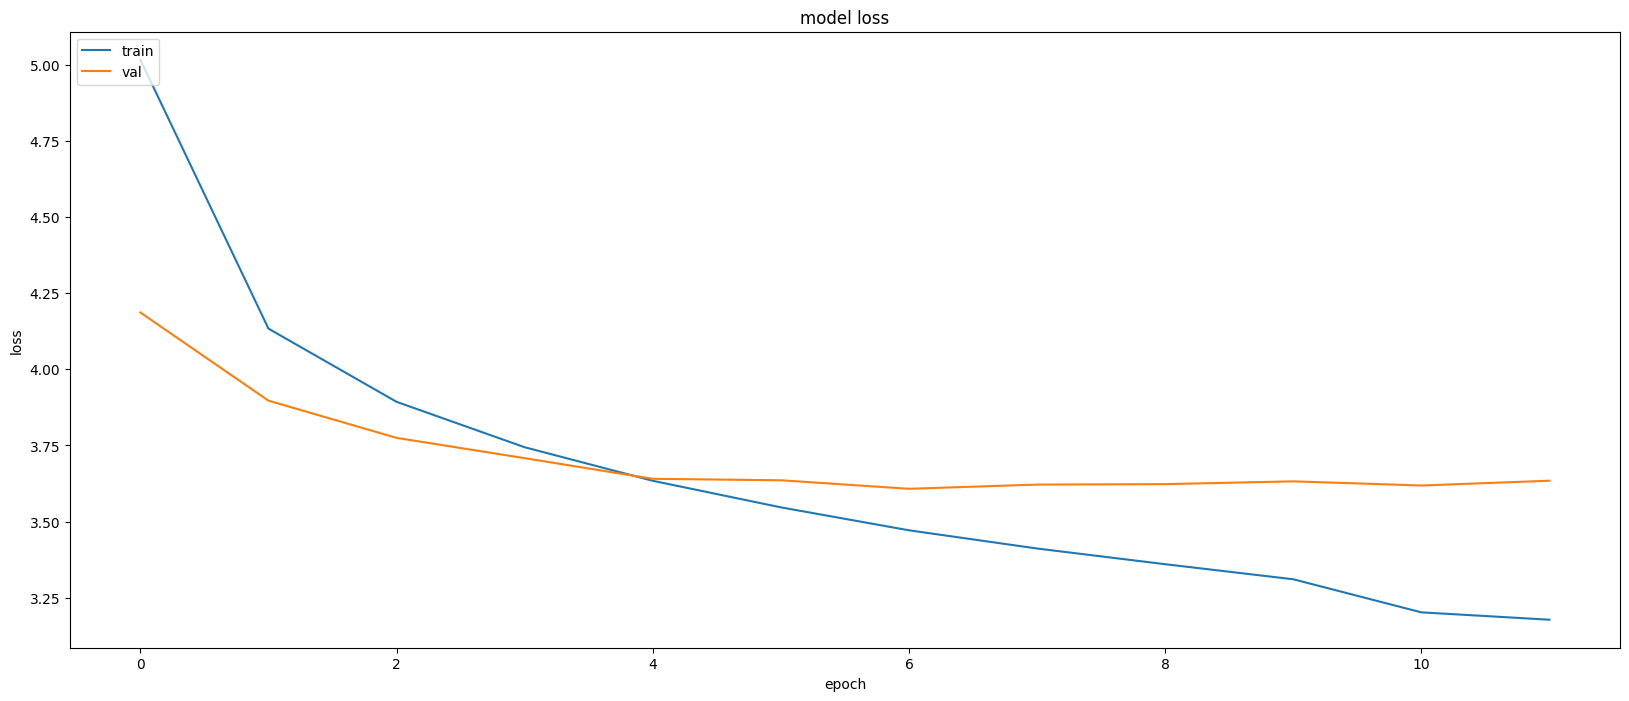

In [24]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# converts integer to corresponding words
def idx_to_word(integer, tokenizer):

  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [26]:
# genrate caption of for a given image by iteratively predicting the next word in the sequence
def predict_caption(model, image, tokenizer, max_length, features):

  feature = features[image]
  in_text = 'startseq'

  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen = max_length)

    y_pred = model.predict([feature, sequence])
    y_pred = np.argmax(y_pred)

    word = idx_to_word(y_pred, tokenizer)

    if word is None:
      break

    in_text += " " + word

    if word == 'endseq':
      break

  return in_text

In [27]:
# select 15 random samples
samples = test.sample(15)
samples.reset_index(drop=True, inplace=True)

for index, record in samples.iterrows():
  img = load_img(os.path.join(image_dir, record['image']), target_size = (img_size, img_size))
  img = img_to_array(img)
  img = img / 255

  caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)

  samples.loc[index, 'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

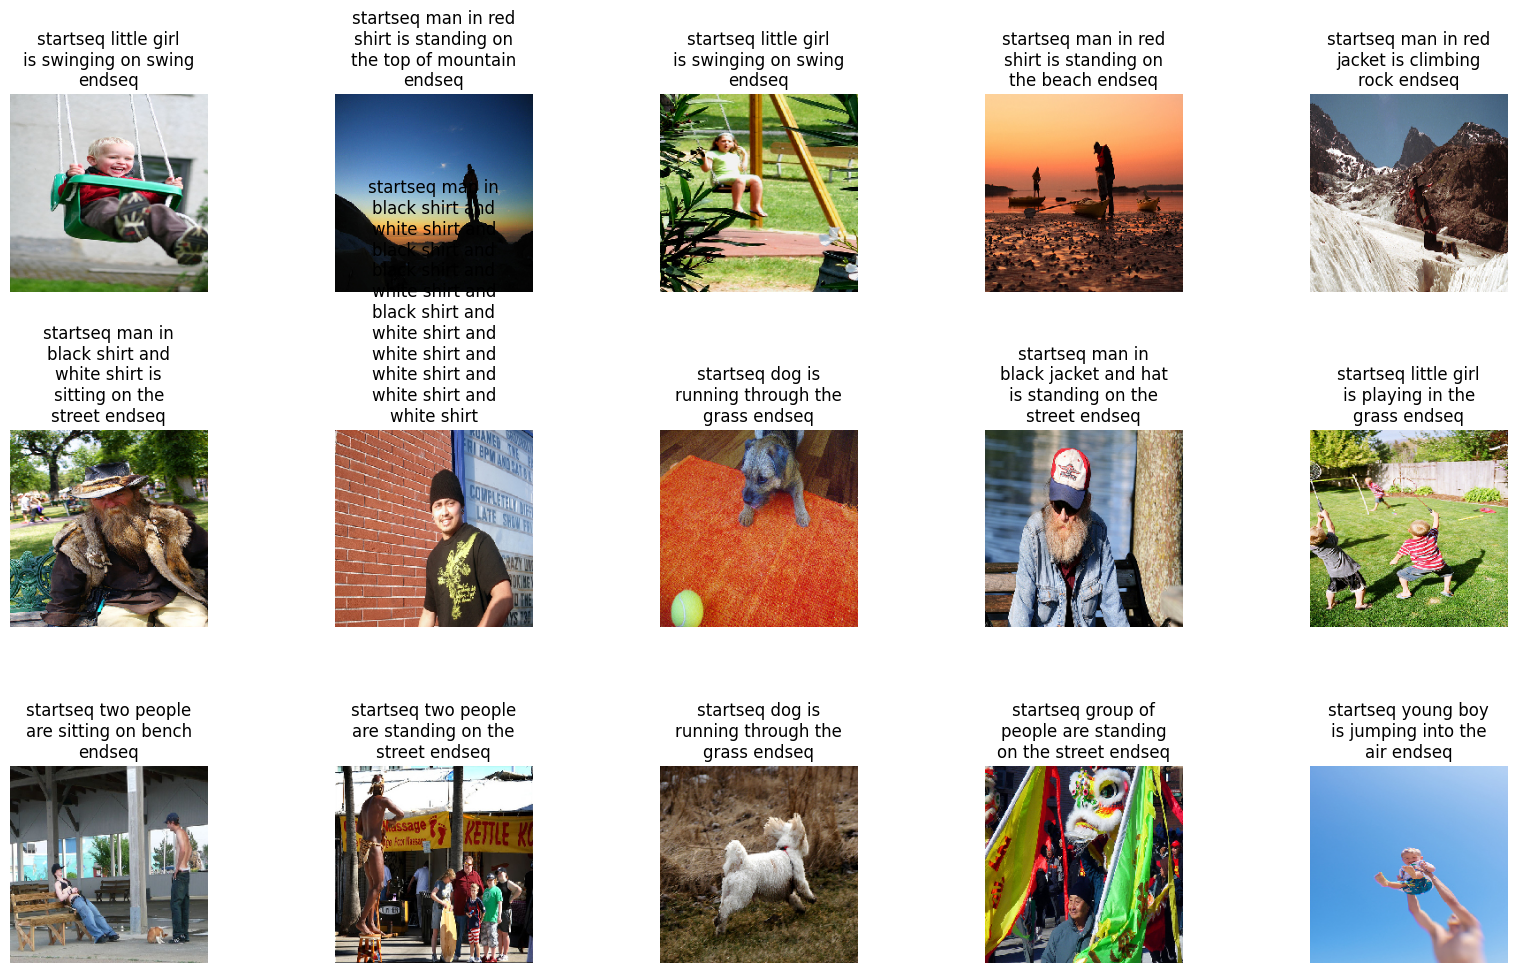

In [28]:
displayImages(samples)